In [1]:
# Standard data science libraries
# Must run this cell first
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import copy as cp
import time

plt.close('all')
sns.set(color_codes=True)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize, least_squares

from sklearn.linear_model import Lasso, LinearRegression

import scipy.stats as st
from scipy import signal
import scipy
from scipy.interpolate import interp1d
from scipy.fftpack import fft, ifft, rfft, irfft

import statsmodels.api as sm

from collections import Counter

import itertools
from itertools import permutations

import sys

import csv

import pyunicorn
from pyunicorn import timeseries
from pyunicorn.timeseries.surrogates import Surrogates

from matplotlib import cm

import os
from os import listdir
from os.path import isfile, join

import random
import ray
import NeuronVasomotionFunc as nvf
import pickle

%matplotlib inline

pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!


In [ ]:
## Import SU pickled data

with open("bs_SU_results_sim_detrended_store_synch.txt", "rb") as fp:   # Unpickling
    raw_bs_data_SU = pickle.load(fp)

SU Data

In [ ]:
## Organize data for actual SU data

# Data is re-formatted to fit into individual cells
total_num_iter = 1
num_files = 43
beg_ind = 0
end_ind = 1200
Tw = 240
des_num_neurons = 25

bs_sig_exp = np.zeros((total_num_iter,1))
bs_score_mat = np.empty((total_num_iter, num_files, (end_ind-beg_ind) - Tw))
bs_neuron_data_storage = np.zeros((total_num_iter, num_files, Tw, des_num_neurons))
bs_PO2_data_storage = np.zeros((total_num_iter, num_files, Tw, des_num_neurons))
bs_corr_mat = np.zeros((total_num_iter, num_files, des_num_neurons))
bs_pvalue_mat = np.zeros((total_num_iter, num_files, des_num_neurons))
bs_SI_mat = np.empty((total_num_iter, num_files, (end_ind-beg_ind) - Tw))

bs_sig_exp[0,:] = raw_bs_data_SU[0][0]
bs_score_mat[0,:,:] = raw_bs_data_SU[0][1]
bs_neuron_data_storage[0,:,:,:] = raw_bs_data_SU[0][2]
bs_PO2_data_storage[0,:,:,:] = raw_bs_data_SU[0][3]
bs_corr_mat[0,:,:] = raw_bs_data_SU[0][4]
bs_pvalue_mat[0,:,:] = raw_bs_data_SU[0][5]
bs_SI_mat[0,:,:] = raw_bs_data_SU[0][9]

In [ ]:
####This sub-script outputs two files and one folder of files ####

### First file: Output synchronization index values for each experiment ###

### Second file: Output summary table for actual data (For each row in the table): Experiment Name, 
### Number of Bonferonni Correlated Neurons, Correlation of each neuron, p-values for each correlation, 
### Time stamps of best fit time window, Number of neurons within experiment, 
### Bonferroni p-value threshold, Synchronization Index value, Percent of neurons in participating cluster
### Neurons in the participating cluster, 

### First folder: Output a file for each experiment, consisting of PO2 and the corresponding Bonferroni 
### correlated neuron for the best fit two minute time window.

# Indicator on whether to output data
output_data = 1

num_iter = bs_neuron_data_storage.shape[0]
num_exp = bs_neuron_data_storage.shape[1]
Tw_length = bs_neuron_data_storage.shape[2]
num_neurons = bs_neuron_data_storage.shape[3]

alpha = .05         # p-value significance level
N = 100             # Number of surrogates to run for Synchronization Index analysis

PI_thresh = .3      # Threshold of participation index in order to be added to participation cluster 
sync_thresh = 0     # Threshold of synchronization index to record experiment's synchronization index

# Initialize variables
SyncValues = []    
sig_sync_counter = 0
cluster_perc_list = []
Synch_neuron_cluster_list = []

for j in np.arange(num_exp):
    exp_pvalue_vec = bs_pvalue_mat[0,j,:]

    temp_num_neurons = np.sum(exp_pvalue_vec > 0)
    exp_pvalue_vec = exp_pvalue_vec[:temp_num_neurons]

    temp_bonf_alpha = .05/temp_num_neurons

    if np.sum(exp_pvalue_vec < temp_bonf_alpha) > 0:
        temp_X_data = bs_neuron_data_storage[0,j,:,:temp_num_neurons]

        X_norm_temp_orig = (temp_X_data - np.mean(temp_X_data, axis = 0))/np.std(temp_X_data, axis = 0)

        X_p = X_norm_temp_orig.T

        cov_mat = np.cov(X_p)

        eig_values, eig_vecs = np.linalg.eig(cov_mat)

        sort_ind = np.argsort(eig_values)
        sorted_eig_values = eig_values[sort_ind]
        sorted_eig_vecs = eig_vecs[:,sort_ind]

        smooth = [1,6]

        sync_ind, PI_mat, _, _ = nvf.CMA_Sync(X_norm_temp_orig, N, sorted_eig_values, 
                                     sorted_eig_vecs, temp_bonf_alpha, smooth)

        PI_vec = PI_mat[0,:]
        
        perc_cluster = (np.sum(PI_vec > PI_thresh))/len(PI_vec)
        cluster_perc_list.append(perc_cluster)
        
        neuron_ind_range = np.arange(1, len(PI_vec)+1)
        synch_cluster_neurons = neuron_ind_range[PI_vec > PI_thresh]
        
        Synch_neuron_cluster_list.append(synch_cluster_neurons)
        
        sync_ind1_value = sync_ind[-1]

        SyncValues.append(sync_ind1_value)

        if sync_ind1_value > sync_thresh:
            sig_sync_counter += 1

if output_data:            
    np.savetxt('[output_folder]/SU_Sync_Ind_Distr_Actual.csv', SyncValues, delimiter=',')

## Output Bonferonni Significant Exp on Actual Data
score_vec = raw_bs_data_SU[0][1]
neuron_series_data = raw_bs_data_SU[0][2]
PO2_series_data = raw_bs_data_SU[0][3]
corr_data = raw_bs_data_SU[0][4]
pvalue_data = raw_bs_data_SU[0][5]
sig_exp_data = raw_bs_data_SU[0][6]

exp_list = []
sig_neuron_num_list = []
corr_list = []
pvalue_list = []
score_vec_list = []
time_stamps = []
pop_neuron_list = []
bonf_alpha_list = []
neuron_series_list = []
PO2_series_list = []

for i in np.arange(corr_data.shape[1]):
    
    temp_full_pvalue = pvalue_data[0,i,:]
    temp_full_corr = corr_data[0,i,:]
    
    num_actual = np.sum(temp_full_pvalue > 0) 
    temp_bonf_alpha = .05/num_actual
    
    temp_pvalue_vec = temp_full_pvalue[:num_actual]
    temp_corr_vec = temp_full_corr[:num_actual]
    
    sig_log = temp_pvalue_vec < temp_bonf_alpha
    
    if np.sum(sig_log) > 0:
        
        neuron_indices = np.arange(1, num_actual+1)
        sig_neurons = neuron_indices[sig_log]
        
        exp_score_vec = score_vec[0, i, :]
        
        max_ind = np.argmax(exp_score_vec)
        
        beg_time_stamp = max_ind/2
        end_time_stamp = (max_ind + Tw)/2
        
        exp_list.append(sig_exp_data[i])
        sig_neuron_num_list.append(list(sig_neurons))
        corr_list.append(temp_corr_vec[sig_log])
        pvalue_list.append(temp_pvalue_vec[sig_log])
        score_vec_list.append(exp_score_vec)
        time_stamps.append(list([beg_time_stamp, end_time_stamp]))
        pop_neuron_list.append(num_actual)
        bonf_alpha_list.append(temp_bonf_alpha)
        neuron_series_list.append(neuron_series_data[0,i,:,:])
        PO2_series_list.append(PO2_series_data[0,i,:,:])

if output_data:

    output_path = '[Insert output path for actual data summary]'

    import csv

    with open(output_path,'w') as result_file:
        wr = csv.writer(result_file, dialect='excel')

        header = ['Experiment', 'Neuron Num(s)', 'Correlation(s)', 'P-value(s)', 'Time Stamps', 
                  'Pop Neuron Size', 'Bonf Alpha', 'Sync Ind', 'Perc Synch', 'Synchronized Neurons']
        wr.writerow(header)

        for i in np.arange(len(exp_list)):
            temp_time_stamps = str(time_stamps[i][0]) + 's-' + str(time_stamps[i][1]) + 's'
            wr.writerow([exp_list[i], sig_neuron_num_list[i], corr_list[i], pvalue_list[i],
                         temp_time_stamps, pop_neuron_list[i], bonf_alpha_list[i], SyncValues[i],
                         cluster_perc_list[i], Synch_neuron_cluster_list[i]])
    
    example_folder_path = '[Insert output path for best examples]'

    if not os.path.isdir(example_folder_path):
        os.mkdir(example_folder_path)
        
    for j in np.arange(len(exp_list)):
        
        temp_exp_name = exp_list[j]
        
        example_output_path = example_folder_path + temp_exp_name + '.csv'
        
        temp_sig_neuron_inds = np.array(sig_neuron_num_list[j])-1
        
        temp_SU_mat = neuron_series_list[j][:, temp_sig_neuron_inds]
        temp_PO2_mat = PO2_series_list[j][:, 0]
        
        temp_PO2_mat = temp_PO2_mat.reshape(-1,1)
        
        norm_SU_mat = (temp_SU_mat - np.mean(temp_SU_mat, axis = 0))/np.std(temp_SU_mat, axis = 0)
        norm_PO2_mat = (temp_PO2_mat - np.mean(temp_PO2_mat, axis = 0))/np.std(temp_PO2_mat, axis = 0)
        
        temp_output_mat = np.concatenate((norm_PO2_mat, norm_SU_mat), axis=1)
        
        with open(example_output_path,'w') as result_file:
            wr = csv.writer(result_file, dialect='excel')

            header = []
            header.append("PO2")
            
            num_sig = len(temp_sig_neuron_inds)

            for k in np.arange(len(temp_sig_neuron_inds)):
                header.append("SU" + str(temp_sig_neuron_inds[k] + 1))
            
            wr.writerow(header)

            for l in np.arange(temp_output_mat.shape[0]):
                
                wr.writerow(temp_output_mat[l,:])   

In [ ]:
### Interval hypothesis testing for synchronization ###

# Determine distribution of synchronization index values
actual_SI_distr = bs_SI_mat.flatten()

# Create histogram
dt = .01
hist_bins = np.arange(0,1 + dt,dt)
x = hist_bins[:-1]
SI_hist = [np.sum((actual_SI_distr < hist_bins[i+1]) & (actual_SI_distr >= hist_bins[i])) 
           for i in np.arange(len(x))]

SI_hist[0] = 0
norm_SI_hist = SI_hist/np.sum(SI_hist)*(1/dt)

sns.distplot(actual_SI_distr)
plt.plot(x, norm_SI_hist)

param_dt = .1
beg_ind = 0
end_ind = 30
alpha_list = np.arange(beg_ind+param_dt, end_ind+param_dt, param_dt)
beta_list = np.arange(beg_ind+param_dt, end_ind+param_dt, param_dt)

MSE_mat = np.zeros((len(alpha_list), len(beta_list)))

for i, alpha in enumerate(alpha_list):
    print(i)
    for j, beta in enumerate(beta_list):
        temp_beta_distr = st.beta.pdf(x, alpha, beta)
        
        temp_MSE = np.mean(np.power(np.ma.masked_invalid((norm_SI_hist - temp_beta_distr)), 2))
        
        MSE_mat[i,j] = temp_MSE
        
alpha_inds = np.argmin(MSE_mat, axis=0)
alpha_min = np.min(MSE_mat, axis=0)

beta_ind = np.argmin(alpha_min)

best_fit_param_ind = [alpha_inds[beta_ind], beta_ind]
best_fit_param_value = [alpha_list[best_fit_param_ind[0]], beta_list[best_fit_param_ind[1]]]

temp_alpha = best_fit_param_value[0]
temp_beta = best_fit_param_value[1]

theor_distr = st.beta.pdf(x, temp_alpha, temp_beta)

output_mat = np.concatenate((x.reshape(-1,1), norm_SI_hist.reshape(-1,1), theor_distr.reshape(-1,1)), axis=1)

output_path = '[output folder for synchroniztion index histogram]/SI_histogram.csv'

with open(output_path, 'w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    
    header = ["Bin", "Empirical Distribution", "Theoretical Distribution"]
    
    wr.writerow(header)
    
    for i in np.arange(output_mat.shape[0]):
        temp_row = output_mat[i,:]
        
        wr.writerow(temp_row)

plt.plot(x, theor_distr, color = 'r')
plt.bar(x, norm_SI_hist, width=dt)

1-st.beta.cdf(.1, temp_alpha, temp_beta)

num_exp = bs_SI_mat.shape[1]

total_exp_list = []
max_synch_value_list = np.zeros((num_exp, 1))
min_synch_value_list = np.zeros((num_exp, 1))
max_synch_pvalue_list = np.zeros((num_exp, 1))
min_synch_pvalue_list = np.zeros((num_exp, 1))

print(len(exp_list))

for i in np.arange(num_exp):
    temp_exp = sig_exp_data[i]
    total_exp_list.append(temp_exp)
    
    temp_score_vec = bs_score_mat[0,i,:]
    temp_SI_vec = bs_SI_mat[0,i,:]
    
    score_max_ind = np.argmax(temp_score_vec)
    max_synch_value = temp_SI_vec[score_max_ind]
    
    score_min_ind = np.argmin(temp_score_vec)
    min_synch_value = temp_SI_vec[score_min_ind]
    
    max_synch_value_list[i] = max_synch_value
    min_synch_value_list[i] = min_synch_value
    
    max_synch_pvalue = 1-st.beta.cdf(max_synch_value, temp_alpha, temp_beta)
    min_synch_pvalue = 1-st.beta.cdf(min_synch_value, temp_alpha, temp_beta)
    
    max_synch_pvalue_list[i] = max_synch_pvalue
    min_synch_pvalue_list[i] = min_synch_pvalue

output_path = '[output folder for interval comparison test]/IntervalComparisonTesting_v2.csv'
    
with open(output_path,'w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    
    header = ["Experiment", "Max_TW_SI", "Min_TW_SI", "Max_TW_pvalue", "Min_TW_pvalue"]
    
    wr.writerow(header)
    
    for i in np.arange(num_exp):
        temp_exp = total_exp_list[i]
        
        if temp_exp in exp_list:
            print(temp_exp)
            temp_row = list((total_exp_list[i], max_synch_value_list[i][0], min_synch_value_list[i][0],
                             max_synch_pvalue_list[i][0], min_synch_pvalue_list[i][0]))
        
            wr.writerow(temp_row)

In [ ]:
# Organize simulated SU data

num_cores = 12          # Number of cpu cores used to run analysis in "Bootstrap Testing.ipynb"
base_ind_value  = 8     # Number of base iterations per core
remainders = 4          # Number of remainders (i.e. number of cores which had base+1 iterations per core)
des_num_var = 15        # Number of neurons per simulated experiment
num_files = 43          # Number of experiments per iteration
beg_ind = 0             # Starting end of experiment duration (.5 second timestep)
end_ind = 1200          # Ending ind of experiment duration (.5 second timestep)
Tw = 240                # Size of time window (.5 second timestep)

iter_indices = np.ones((num_cores, 1))
iter_indices = iter_indices*base_ind_value
    
for j in np.arange(remainders):
    iter_indices[j] += 1

iter_indices_cumsum = np.cumsum(iter_indices)

total_num_iter = 100

bs_sig_exp = np.zeros((total_num_iter,1))
bs_score_mat = np.empty((total_num_iter, num_files, (end_ind-beg_ind) - Tw))
bs_neuron_data_storage = np.zeros((total_num_iter, num_files, Tw, des_num_var))
bs_PO2_data_storage = np.zeros((total_num_iter, num_files, Tw, des_num_var))
bs_corr_mat = np.zeros((total_num_iter, num_files, des_num_var))
bs_pvalue_mat = np.zeros((total_num_iter, num_files, des_num_var))
bs_synch_score_mat = np.empty((total_num_iter, num_files, (end_ind-beg_ind) - Tw))

for i in np.arange(len(iter_indices)):
    if i == 0:
        bot_ind = 0
        top_ind = int(iter_indices_cumsum[i])
    else:
        bot_ind = int(iter_indices_cumsum[i-1])
        top_ind = int(iter_indices_cumsum[i])
    
    bs_sig_exp[bot_ind:top_ind,:] = raw_bs_data_SU[i][0]
    bs_score_mat[bot_ind:top_ind,:,:] = raw_bs_data_SU[i][1]
    bs_neuron_data_storage[bot_ind:top_ind,:,:,:] = raw_bs_data_SU[i][2]
    bs_PO2_data_storage[bot_ind:top_ind,:,:,:] = raw_bs_data_SU[i][3]
    bs_corr_mat[bot_ind:top_ind,:,:] = raw_bs_data_SU[i][4]
    bs_pvalue_mat[bot_ind:top_ind,:,:] = raw_bs_data_SU[i][5]
    bs_synch_score_mat[bot_ind:top_ind,:,:] = raw_bs_data_SU[i][9]

In [ ]:
## Recalculate number of significant experiments for simulated data

num_iter = bs_neuron_data_storage.shape[0]
num_exp = bs_neuron_data_storage.shape[1]
Tw_length = bs_neuron_data_storage.shape[2]
num_neurons = bs_neuron_data_storage.shape[3]

alpha = .05    # p-value significance level
N = 100        # Number of surrogates to run for Synchronization Index analysis

sig_exp_mat = np.zeros((num_iter,1))

for i in np.arange(num_iter):

    sig_exp_counter = 0
    
    for j in np.arange(num_exp):
        exp_pvalue_vec = bs_pvalue_mat[i,j,:]
        
        temp_num_neurons = np.sum(exp_pvalue_vec > 0)
        exp_pvalue_vec = exp_pvalue_vec[:temp_num_neurons]
    
        temp_bonf_alpha = .05/temp_num_neurons
        
        if np.sum(exp_pvalue_vec < temp_bonf_alpha) > 0:
            sig_exp_counter += 1
        
    sig_exp_mat[i] = sig_exp_counter

output_path = '/home/evan/Projects/NeuronVasomotion/StatSUResults/SU_Sim_Distr_NumBonf_detrend.csv'

np.savetxt(output_path, sig_exp_mat, delimiter=',')

In [ ]:
## Output best examples of SU surrogate data

### First folder: Outputs 10 ten examples of simulated SU and PO2 times series over a two minute time window.
### Examples are output in order from best to worst correlations (1st = best correlation, 10th = 10th best correlation)

output_data = 0

# Pull parameters
num_iter = bs_corr_mat.shape[0]
num_exp = bs_corr_mat.shape[1]
num_SU = bs_corr_mat.shape[2]

Tw_length = bs_neuron_data_storage.shape[2]

# Set number of examples to generate
num_examples = 10

# Initialized matrices to find ts with best correlations
best_corr_inds = np.zeros((num_iter, 2))
best_corr_values = np.zeros(num_iter)

# Find experiments and single units with best correlations
for i in np.arange(num_iter):
    best_iter_corr_inds = np.zeros(num_exp)
    best_iter_corr_values = np.zeros(num_exp)

    for j in np.arange(num_exp):

        temp_corr_vec = bs_corr_mat[i,j,:]

        best_iter_corr_inds[j] = np.nanargmax(temp_corr_vec) 
        best_iter_corr_values[j] = np.nanmax(temp_corr_vec)

    best_exp_ind = np.argmax(best_iter_corr_values)
    best_SU_ind = best_iter_corr_inds[best_exp_ind]

    best_corr_inds[i,0] = best_exp_ind
    best_corr_inds[i,1] = best_SU_ind

    best_corr_values[i] = np.max(best_iter_corr_values)

# Determine iterations with the highest correlations
best_iter_list = np.argsort(best_corr_values)
best_iter_list = best_iter_list[::-1]

best_examples_mat = np.zeros((Tw_length, 2, num_examples))

for k in np.arange(num_examples):
    
    best_iter = best_iter_list[k]    
    best_corr_ind = [best_iter, int(best_corr_inds[best_iter,0]), int(best_corr_inds[best_iter,1])]

    best_SU_series = bs_neuron_data_storage[best_corr_ind[0], best_corr_ind[1], :, best_corr_ind[2]]
    best_PO2_series = bs_PO2_data_storage[best_corr_ind[0], best_corr_ind[1], :, best_corr_ind[2]]
    
    
    best_examples_mat[:, 0, k] = best_PO2_series
    best_examples_mat[:, 1, k] = best_SU_series

plt.plot(best_examples_mat[:,0,1])
plt.plot(best_examples_mat[:,1,1])

if output_data:

    for k in np.arange(num_examples):
    
        output_folder = '[output folder for best simulated examples]/Best_Simulated_SU_Examples_v2/'
        
        if not os.path.isdir(output_folder):
            os.mkdir(output_folder)
        
        output_mat = best_examples_mat[:,:,k]

        output_path = join(output_folder, 'best_SU_sim_example_detrend_case'+str(int(k+1))+'.csv')
        
        with open(output_path,'w') as result_file:
            wr = csv.writer(result_file, dialect='excel')

            wr.writerow(['PO2', "SU"])

            for i in np.arange(output_mat.shape[0]):
                temp_row = list((output_mat[i,0], output_mat[i,1]))

                wr.writerow(temp_row)

In [ ]:
## Determine number of significant synchronizations for SU data

num_iter = bs_neuron_data_storage.shape[0]
num_exp = bs_neuron_data_storage.shape[1]
Tw_length = bs_neuron_data_storage.shape[2]
num_neurons = bs_neuron_data_storage.shape[3]

alpha = .05      # p-value significance level 
N = 100          # Number of surrogates to run for Synchronization Index analysis

sync_thresh = 0

sig_sync_mat = np.zeros((num_iter,1))
sync_data_mat = np.zeros((num_iter, num_exp))

sync_values = []

for i in np.arange(num_iter):
    
    print(i)
    
    sig_sync_counter = 0
    
    for j in np.arange(num_exp):
        exp_pvalue_vec = bs_pvalue_mat[i,j,:]
        #print(exp_pvalue_vec)
        
        temp_num_neurons = np.sum(exp_pvalue_vec > 0)
        exp_pvalue_vec = exp_pvalue_vec[:temp_num_neurons]
    
        temp_bonf_alpha = .05/temp_num_neurons
        #print(temp_bonf_alpha)
        
        if np.sum(exp_pvalue_vec < temp_bonf_alpha) > 0:
            temp_X_data = bs_neuron_data_storage[i,j,:,:temp_num_neurons]
            
            #print(temp_X_data)
            
            X_norm_temp_orig = (temp_X_data - np.mean(temp_X_data, axis = 0))/np.std(temp_X_data, axis = 0)
            
            X_p = X_norm_temp_orig.T

            cov_mat = np.cov(X_p)
        
            eig_values, eig_vecs = np.linalg.eig(cov_mat)

            sort_ind = np.argsort(eig_values)
            sorted_eig_values = eig_values[sort_ind]
            sorted_eig_vecs = eig_vecs[:,sort_ind]

            pca = X_p
        
            smooth = [1,6]
        
            sync_ind, _, _, _ = nvf.CMA_Sync(X_norm_temp_orig, N, sorted_eig_values, 
                                         sorted_eig_vecs, temp_bonf_alpha, smooth)
            
            sync_ind1_value = sync_ind[-1]
            
            sync_data_mat[i,j] = sync_ind1_value
            
            sync_values.append(sync_ind1_value)
            
            if sync_ind1_value > sync_thresh:
                sig_sync_counter += 1
    
    sig_sync_mat[i] = sig_sync_counter
    
np.savetxt("/home/evan/Projects/NeuronVasomotion/StatSUResults/SU_Sim_Distr_Sync_Ind_detrend_v2.csv", sync_values, delimiter=',')
np.savetxt("/home/evan/Projects/NeuronVasomotion/StatSUResults/SU_Sim_Distr_NumSigExp_Sync_detrend_v2.csv", sig_sync_mat, delimiter=',')

LFP Data

In [7]:
import pickle

with open("/home/evan/Projects/NeuronVasomotion/LFP_pickle_files/bs_LFP_results_sim_detrended_v2.txt", "rb") as fp:   # Unpickling
    raw_bs_data_LFP = pickle.load(fp)

In [3]:
### Output summary table for actual data. Each row consists of the frequency range (band), 
### number of significant experiments, followed by all the significant experiments for the corresponding band.

# Indicator whether to output LFP data
output_data = 1

band_ranges = ['0-4Hz', '4-7Hz', '8-15Hz', '16-31Hz', '30-50Hz', '50-80Hz', '80-100Hz']

if output_data:
    
    output_path = '/home/evan/Projects/NeuronVasomotion/Output_LFP_v2/LFP_band_actual_distr.csv'

    with open(output_path,'w') as result_file:
        wr = csv.writer(result_file, dialect='excel')

        for i in np.arange(7):
            temp_exp_list = raw_bs_data_LFP[i][8]
            temp_num_sig_exp = raw_bs_data_LFP[i][0][0][0]
            temp_band_range = band_ranges[i]

            temp_row = []

            temp_row.append(temp_band_range)
            temp_row.append(temp_num_sig_exp)

            for j in np.arange(len(temp_exp_list)):
                temp_row.append(temp_exp_list[j])

            wr.writerow(temp_row)

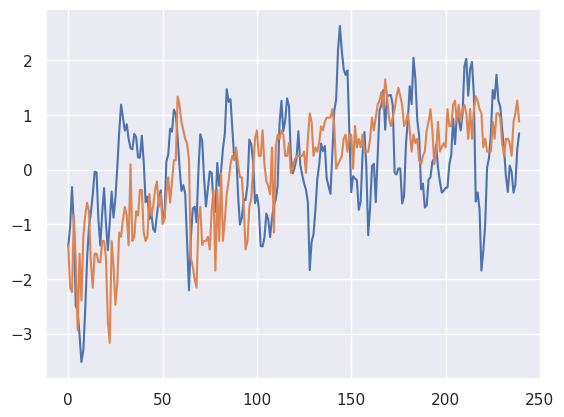

In [6]:
## Organize actual LFP data
## And Output best actual LFP examples

output_data = 1

total_num_iter = 1
num_bands = 7
num_files = 43
beg_ind = 0
end_ind = 1191
Tw = 240

bs_sig_exp = np.zeros((total_num_iter,num_bands))
bs_score_mat = np.empty((total_num_iter, num_files, (end_ind-beg_ind) - Tw, num_bands))
bs_neuron_data_storage = np.zeros((total_num_iter, num_files, Tw, num_bands))
bs_PO2_data_storage = np.zeros((total_num_iter, num_files, Tw, num_bands))
bs_corr_mat = np.zeros((total_num_iter, num_files, num_bands))
bs_pvalue_mat = np.zeros((total_num_iter, num_files, num_bands))

for i in np.arange(7):
        bs_sig_exp[:,i] = raw_bs_data_LFP[i][0].ravel()
        bs_score_mat[:, :, :, i] = raw_bs_data_LFP[i][1]
        bs_neuron_data_storage[:, :, :, i] = raw_bs_data_LFP[i][2][:,:,:,0]
        bs_PO2_data_storage[:, :, :, i] = raw_bs_data_LFP[i][3][:,:,:,0]
        bs_corr_mat[:, :, i] = raw_bs_data_LFP[i][4][:,:,0]
        bs_pvalue_mat[:, :, i] = raw_bs_data_LFP[i][5][:,:,0]

actual_exp_list = raw_bs_data_LFP[0][6]
        
num_examples = 10
        
best_corr_ind_mat = np.zeros((7,num_examples))
best_LFP_examples = np.zeros((Tw, num_bands, num_examples))
best_PO2_examples = np.zeros((Tw, num_bands, num_examples))

for i in np.arange(num_bands):
    
    exp_corr_vec = bs_corr_mat[0,:,i]
    
    best_corr_inds = np.argsort(exp_corr_vec)
    best_corr_inds = best_corr_inds[::-1]
    
    for k in np.arange(num_examples):
        best_exp_ind = best_corr_inds[k]

        best_corr_ind_mat[i, k] = best_exp_ind

        best_LFP_examples[:, i, k] = bs_neuron_data_storage[0, best_exp_ind, :, i]
        best_PO2_examples[:, i, k] = bs_PO2_data_storage[0, best_exp_ind, :, i]

LFP_num = 3
case_num = 5

norm_best_LFP_examples = (best_LFP_examples - np.mean(best_LFP_examples, axis=0))/np.std(best_LFP_examples, axis=0)
norm_best_PO2_examples = (best_PO2_examples - np.mean(best_PO2_examples, axis=0))/np.std(best_PO2_examples, axis=0)

plt.plot(norm_best_LFP_examples[:,LFP_num, case_num])
plt.plot(norm_best_PO2_examples[:,LFP_num, case_num])

if output_data:

    for k in np.arange(num_examples):

        temp_PO2_examples = norm_best_PO2_examples[:,:,k]
        temp_LFP_examples = norm_best_LFP_examples[:,:,k]
        
        output_folder = '/home/evan/Projects/NeuronVasomotion/LFP_best_examples_actual/'

        if not os.path.isdir(output_folder):
            os.mkdir(output_folder)
            
        output_path = output_folder + 'LFP_actual_examples_case' + str(int(k+1)) + '.csv'    
        
        with open(output_path,'w') as result_file:
            wr = csv.writer(result_file, dialect='excel')

            num_obs = temp_PO2_examples.shape[0]
            num_bands = temp_PO2_examples.shape[1]
            
            band_ranges = ['0-4Hz', '4-7Hz', '8-15Hz', '16-31Hz', '30-50Hz', '50-80Hz', '80-100Hz']
            header1 = []
            header2 = []
            exp_header = []
            tw_header = []
            
            for h in np.arange(num_bands):
                if h == 0:
                    header1.append("PO2")
                else:
                    header1.append("")
                    
                header2.append(band_ranges[h])
                
                best_exp_ind = int(best_corr_ind_mat[h, k])
                
                temp_exp = actual_exp_list[best_exp_ind]
                exp_header.append(temp_exp)
                
                max_ind = np.argmax(bs_score_mat[0, best_exp_ind, :, h])
                tw_string = str(max_ind/2) + "s-" + str((max_ind + 240)/2) + "s"
                tw_header.append(tw_string)
            
            header1.append("")
            header2.append("")
            exp_header.append("")
            tw_header.append("")
            
            for h in np.arange(num_bands):
                if h == 0:
                    header1.append("LFP")
                else:
                    header1.append("")
                
                header2.append(band_ranges[h])
                
                best_exp_ind = int(best_corr_ind_mat[h, k])
                
                temp_exp = actual_exp_list[best_exp_ind]
                exp_header.append(temp_exp)
                
                max_ind = np.argmax(bs_score_mat[0, best_exp_ind, :, h])
                tw_string = str(max_ind/2) + "s-" + str((max_ind + 240)/2) + "s"
                tw_header.append(tw_string)
            
            wr.writerow(header1)
            wr.writerow(header2)
            wr.writerow(exp_header)
            wr.writerow(tw_header)
            
            for i in np.arange(num_obs):
                temp_list = []
                
                for j in np.arange(num_bands):
                    temp_list.append(temp_PO2_examples[i,j])
                
                temp_list.append("")
                
                for j in np.arange(num_bands):
                    temp_list.append(temp_LFP_examples[i,j])
                    
                wr.writerow(temp_list)

In [ ]:
### Determine synchronization values/percentage on LFP data

alpha = .05       # p-value significance level
N = 100           # Number of surrogates to run for Synchronization Index analysis
PI_thresh = .3    # Threshold of participation index in order to be added to participation cluster 

output_folder = '/home/evan/Projects/NeuronVasomotion/LFP_stat_analysis/'

for i in np.arange(num_bands):
    
    sig_exp_list = raw_bs_data_LFP[i][8]
    
    temp_exp_list = []
    sync_values = []
    cluster_perc_list = []
    max_tw_list = []
    
    for j in np.arange(num_files):
        
        exp_file = raw_bs_data_LFP[0][6][j]
        
        if exp_file in sig_exp_list:
            
            temp_exp_list.append(exp_file)
            
            # Determine time window of max R value
            temp_score_vec = bs_score_mat[0,j,:,i]
            max_tw_ind = np.argmax(temp_score_vec)
            temp_beg_ind = max_tw_ind
            temp_end_ind = max_tw_ind + Tw
            
            tw_string = str(temp_beg_ind/2) + "s-" + str(temp_end_ind/2) + "s"  
            max_tw_list.append(tw_string)
            
            # Pull neuron data corresponding to the LFP experiment
            cut_flname = exp_file[:-8]
            smry_flname = cut_flname + "_SummarySmoothed.csv"
            smry_data = np.genfromtxt('[Path to neuron data]'
                          + smry_flname, delimiter = ',')
            neuron_data = smry_data[:,3:]
            
            # Select appropriate time window for neuron data
            neuron_data = neuron_data[temp_beg_ind:temp_end_ind,:]
        
            # Initialize Bonferroni alpha sig level for CMA analysis
            temp_num_neurons = neuron_data.shape[1]    
            temp_bonf_alpha = .05/temp_num_neurons
            
            # Normalize time window neuron data and calculate eigvalues and eigvectors to run CMA analysis
            X_norm_temp_orig = (neuron_data - np.mean(neuron_data, axis = 0))/np.std(neuron_data, axis = 0)
            X_p = X_norm_temp_orig.T
            cov_mat = np.cov(X_p)
            eig_values, eig_vecs = np.linalg.eig(cov_mat)
            sort_ind = np.argsort(eig_values)
            sorted_eig_values = eig_values[sort_ind]
            sorted_eig_vecs = eig_vecs[:,sort_ind]

            # Initialized smoothing time window
            smooth = [1,6]
            
            sync_ind_vec, PI_mat, _, _ = nvf.CMA_Sync(X_norm_temp_orig, N, sorted_eig_values, 
                                                      sorted_eig_vecs, temp_bonf_alpha, smooth)
            
            sync_ind_value = sync_ind_vec[-1]
            sync_values.append(sync_ind_value)
            
            PI_vec = PI_mat[0,:]
            perc_cluster = (np.sum(PI_vec > PI_thresh))/len(PI_vec)
            cluster_perc_list.append(perc_cluster)
            
    temp_file_ext = "Band" + str(i+1) + ".csv"
    output_path = output_folder + temp_file_ext
    
    with open(output_path,'w') as result_file:
        wr = csv.writer(result_file, dialect='excel')

        header = ["Experiment", "Synchronization Index", "Percent in Cluster", "Time Window"]
        wr.writerow(header)

        for k in np.arange(len(temp_exp_list)):
            int_k  = int(k)
            temp_row = [temp_exp_list[int_k], sync_values[int_k], cluster_perc_list[int_k], max_tw_list[int_k]]
            wr.writerow(temp_row)
                

In [8]:
# Organize simulated LFP data into individual matrices
total_num_iter = 100
num_files = 43
num_bands = 7

beg_ind = 0
end_ind = 1191
Tw = 240

bs_sig_exp = np.zeros((total_num_iter,num_bands))
bs_score_mat = np.empty((total_num_iter, num_files, (end_ind-beg_ind) - Tw, num_bands))
bs_neuron_data_storage = np.zeros((total_num_iter, num_files, Tw, num_bands))
bs_PO2_data_storage = np.zeros((total_num_iter, num_files, Tw, num_bands))
bs_corr_mat = np.zeros((total_num_iter, num_files, num_bands))
bs_pvalue_mat = np.zeros((total_num_iter, num_files, num_bands))

for i in np.arange(10):
    column_ind = int(np.floor(i/2))
    
    bound_ind = 50
    
    if i % 2 == 0:
        bs_sig_exp[:bound_ind,column_ind] = raw_bs_data_LFP[i][0].ravel()
        bs_score_mat[:bound_ind, :, :, column_ind] = raw_bs_data_LFP[i][1]
        bs_neuron_data_storage[:bound_ind, :, :, column_ind] = raw_bs_data_LFP[i][2][:,:,:,0]
        bs_PO2_data_storage[:bound_ind, :, :, column_ind] = raw_bs_data_LFP[i][3][:,:,:,0]
        bs_corr_mat[:bound_ind, :, column_ind] = raw_bs_data_LFP[i][4][:,:,0]
        bs_pvalue_mat[:bound_ind, :, column_ind] = raw_bs_data_LFP[i][5][:,:,0]
        
    else:
        bs_sig_exp[bound_ind:, column_ind] = raw_bs_data_LFP[i][0].ravel()
        bs_score_mat[bound_ind:, :, :, column_ind] = raw_bs_data_LFP[i][1]
        bs_neuron_data_storage[bound_ind:, :, :, column_ind] = raw_bs_data_LFP[i][2][:,:,:,0]
        bs_PO2_data_storage[bound_ind:, :, :, column_ind] = raw_bs_data_LFP[i][3][:,:,:,0]
        bs_corr_mat[bound_ind:, :, column_ind] = raw_bs_data_LFP[i][4][:,:,0]
        bs_pvalue_mat[bound_ind:, :, column_ind] = raw_bs_data_LFP[i][5][:,:,0]        
        
bs_sig_exp[:, 5] = raw_bs_data_LFP[10][0].ravel()
bs_score_mat[:, :, :, 5] = raw_bs_data_LFP[10][1]
bs_neuron_data_storage[:, :, :, 5] = raw_bs_data_LFP[10][2][:,:,:,0]
bs_PO2_data_storage[:, :, :, 5] = raw_bs_data_LFP[10][3][:,:,:,0]
bs_corr_mat[:, :, 5] = raw_bs_data_LFP[10][4][:,:,0]
bs_pvalue_mat[:, :, 5] = raw_bs_data_LFP[10][5][:,:,0]

bs_sig_exp[:, 6] = raw_bs_data_LFP[11][0].ravel()
bs_score_mat[:, :, :, 6] = raw_bs_data_LFP[11][1]
bs_neuron_data_storage[:, :, :, 6] = raw_bs_data_LFP[11][2][:,:,:,0]
bs_PO2_data_storage[:, :, :, 6] = raw_bs_data_LFP[11][3][:,:,:,0]
bs_corr_mat[:, :, 6] = raw_bs_data_LFP[11][4][:,:,0]
bs_pvalue_mat[:, :, 6] = raw_bs_data_LFP[11][5][:,:,0]

print(bs_neuron_data_storage.shape)

(100, 43, 240, 7)


0
1
2
3
4
5
6


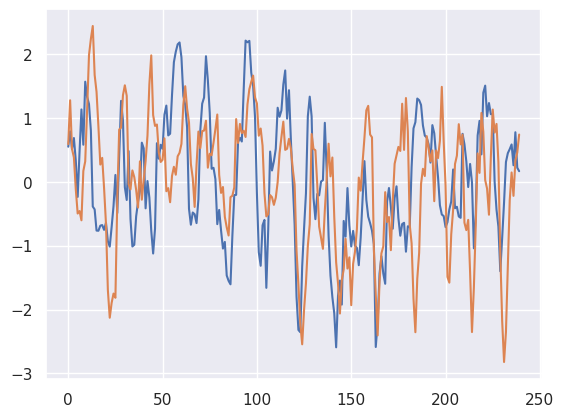

In [10]:
## Output best examples of LFP surrogate data

output_data = 1

bonf_alpha = .05/7

num_examples = 10

# Band_num, iter_ind, exp_ind
max_corr_ind = np.zeros((num_bands, 2, num_examples))

for z in np.arange(num_bands):

    temp_max_corrs = np.zeros(total_num_iter)
    temp_max_corrs_inds = np.zeros(total_num_iter)

    for i in np.arange(total_num_iter):

        exp_corr_list = bs_corr_mat[i,:,z]
        actual_corr_list = np.zeros(len(exp_corr_list))

        sig_corr_log = bs_pvalue_mat[i,:,z] < bonf_alpha 
        actual_corr_list[sig_corr_log] = exp_corr_list[sig_corr_log]

        temp_max_corrs[i] = np.max(actual_corr_list)
        temp_max_corrs_inds[i] = np.argmax(actual_corr_list)

    best_corr_inds = np.argsort(temp_max_corrs)
    best_corr_inds = best_corr_inds[::-1]

    for k in np.arange(num_examples):
    
        best_ind = best_corr_inds[k]

        max_corr_ind[z, 0, k] = best_ind
        max_corr_ind[z, 1, k] = temp_max_corrs_inds[best_ind]
    
LFP_examples = np.zeros((Tw, num_bands, num_examples))
PO2_examples = np.zeros((Tw, num_bands, num_examples))
    
for z in np.arange(num_bands):

    print(z)
    
    for k in np.arange(num_examples):
    
        iter_id = int(max_corr_ind[z,0,k])
        exp_id = int(max_corr_ind[z,1,k])

        LFP_examples[:,z,k] = bs_neuron_data_storage[iter_id, exp_id, :, z]
        PO2_examples[:,z,k] = bs_PO2_data_storage[iter_id, exp_id, :, z]

LFP_examples_norm = (LFP_examples - np.mean(LFP_examples, axis=0))/np.std(LFP_examples, axis=0)
PO2_examples_norm = (PO2_examples - np.mean(PO2_examples, axis=0))/np.std(PO2_examples, axis=0)

exp_num = 0

plt.plot(LFP_examples_norm[:,3,2])
plt.plot(PO2_examples_norm[:,3,2])

if output_data:

    for k in np.arange(num_examples):

        temp_PO2_examples = PO2_examples_norm[:,:,k]
        temp_LFP_examples = LFP_examples_norm[:,:,k]
        
        output_path = '/home/evan/Projects/NeuronVasomotion/LFP_best_examples_sim/LFP_sim_examples_case' + str(int(k+1)) + '.csv'

        with open(output_path,'w') as result_file:
            wr = csv.writer(result_file, dialect='excel')

            num_obs = temp_PO2_examples.shape[0]
            num_bands = temp_PO2_examples.shape[1]
            
            band_ranges = ['0-4Hz', '4-7Hz', '8-15Hz', '16-31Hz', '30-50Hz', '50-80Hz', '80-100Hz']
            header1 = []
            header2 = []
            
            for h in np.arange(num_bands):
                if h == 0:
                    header1.append("PO2")
                else:
                    header1.append("")
                    
                header2.append(band_ranges[h])
            
            header1.append("")
            header2.append("")
            
            for h in np.arange(num_bands):
                if h == 0:
                    header1.append("LFP")
                else:
                    header1.append("")
                
                header2.append(band_ranges[h])
            
            wr.writerow(header1)
            wr.writerow(header2)
            
            for i in np.arange(num_obs):
                temp_list = []
                
                for j in np.arange(num_bands):
                    temp_list.append(temp_PO2_examples[i,j])
                
                temp_list.append("")
                
                for j in np.arange(num_bands):
                    temp_list.append(temp_LFP_examples[i,j])
                    
                wr.writerow(temp_list)

In [14]:
## For each iteration, output the number of significantly Bonferroni correlated cases for each LFP band
band_distr_sim = np.zeros((100,7))

for i in np.arange(10):
    column_ind = int(np.floor(i/2))
    
    if i % 2 == 0:
        band_distr_sim[:50,column_ind] = raw_bs_data_LFP[i][0].ravel()
    else:
        band_distr_sim[50:,column_ind] = raw_bs_data_LFP[i][0].ravel()
        
band_distr_sim[:,5] = raw_bs_data_LFP[10][0].ravel()
band_distr_sim[:,6] = raw_bs_data_LFP[11][0].ravel()

band_ranges = ['0-4Hz', '4-7Hz', '8-15Hz', '16-31Hz', '30-50Hz', '50-80Hz', '80-100Hz']

output_path = '/home/evan/Projects/NeuronVasomotion/LFP_band_distr_v2/LFP_band_distr.csv'

import csv

with open(output_path,'w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    
    wr.writerow(band_ranges)
    
    for i in np.arange(band_distr_sim.shape[0]):
        wr.writerow(band_distr_sim[i,:])